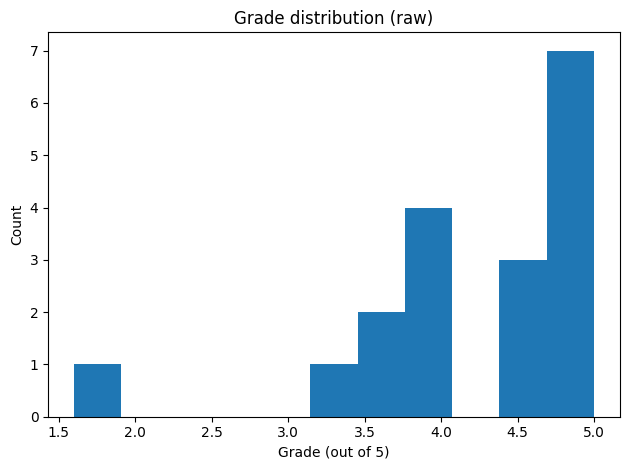

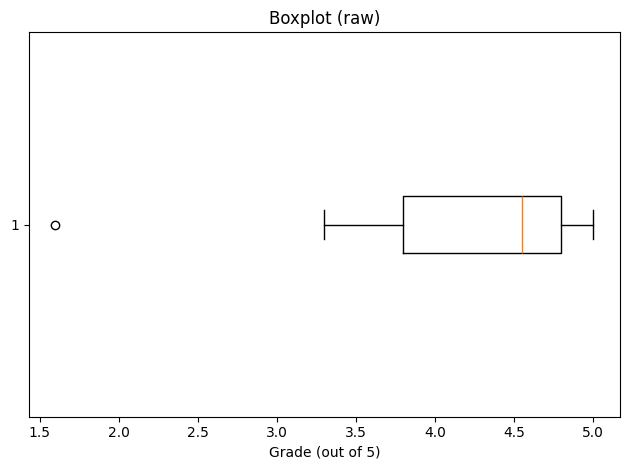


=== Grade Summary (out of 5) ===
                  file: /Users/floorbroekgaarden/Library/Mobile Documents/com~apple~CloudDocs/Documents/Teaching/explosiveUniverse/exams/grades.csv
          grade_column: grades
             max_score: 5.000
          n_total_rows: 18
        n_valid_grades: 18
n_missing_or_non_numeric: 0
                  mean: 4.206
                median: 4.550
                   std: 0.867
                   min: 1.600
                    q1: 3.800
                    q3: 4.800
                   max: 5.000
          mean_percent: 84.111
        median_percent: 91.000
        n_iqr_outliers: 1


,grade_out_of_5,percent,letter
0,4.0,80.0,B-
1,4.6,92.0,A-
2,3.6,72.0,C-
3,1.6,32.0,F
4,3.8,76.0,C



Wrote outputs to: /Users/floorbroekgaarden/Projects/GitHub/teaching/ASTR 121/grade_report


In [9]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
FILE_PATH = Path(r"/Users/floorbroekgaarden/Library/Mobile Documents/com~apple~CloudDocs/Documents/Teaching/explosiveUniverse/exams/grades.csv")
df = pd.read_csv(FILE_PATH)

MAX_SCORE = 5
OUTDIR = Path("grade_report")
BINS = 11  # nice for 0–5 in 0.5-ish resolution; change as desired

def pick_grade_column(df: pd.DataFrame, column: str | None = None) -> str:
    if column is not None:
        if column not in df.columns:
            raise ValueError(f"column '{column}' not found. Columns: {list(df.columns)}")
        return column

    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if len(numeric_cols) == 1:
        return numeric_cols[0]

    common = ["total", "score", "grade", "final", "points", "overall"]
    lowered = {c.lower(): c for c in df.columns}
    for key in common:
        if key in lowered:
            return lowered[key]

    raise ValueError(
        "Could not infer grade column. Pass column='...'.\n"
        f"Columns: {list(df.columns)}\nNumeric columns: {numeric_cols}"
    )

def letter_grade_from_percent(pct: float) -> str:
    if np.isnan(pct):
        return ""
    if pct >= 97: return "A+"
    if pct >= 93: return "A"
    if pct >= 90: return "A-"
    if pct >= 87: return "B+"
    if pct >= 83: return "B"
    if pct >= 80: return "B-"
    if pct >= 77: return "C+"
    if pct >= 73: return "C"
    if pct >= 70: return "C-"
    if pct >= 67: return "D+"
    if pct >= 63: return "D"
    if pct >= 60: return "D-"
    return "F"

def iqr_outliers(x: np.ndarray) -> np.ndarray:
    q1, q3 = np.quantile(x, [0.25, 0.75])
    iqr = q3 - q1
    lo = q1 - 1.5 * iqr
    hi = q3 + 1.5 * iqr
    return (x < lo) | (x > hi)

# --- Load ---
df = pd.read_csv(FILE_PATH)
grade_col = pick_grade_column(df)

grades = pd.to_numeric(df[grade_col], errors="coerce")
valid = grades.dropna()
if valid.empty:
    raise ValueError(f"No numeric grades found in column '{grade_col}'")

# --- Compute ---
percent = valid / MAX_SCORE * 100.0
x = valid.to_numpy(dtype=float)

summary = {
    "file": str(FILE_PATH),          # <-- convert Path to string
    "grade_column": str(grade_col),
    "max_score": float(MAX_SCORE),
    "n_total_rows": int(len(df)),
    "n_valid_grades": int(len(valid)),
    "n_missing_or_non_numeric": int(len(df) - len(valid)),
    "mean": float(np.mean(x)),
    "median": float(np.median(x)),
    "std": float(np.std(x, ddof=1)) if len(x) > 1 else float("nan"),
    "min": float(np.min(x)),
    "q1": float(np.quantile(x, 0.25)),
    "q3": float(np.quantile(x, 0.75)),
    "max": float(np.max(x)),
    "mean_percent": float(np.mean(percent)),
    "median_percent": float(np.median(percent)),
    "n_iqr_outliers": int(iqr_outliers(x).sum()),
}

# --- Export tables ---
OUTDIR.mkdir(parents=True, exist_ok=True)
(Path(OUTDIR) / "summary.json").write_text(json.dumps(summary, indent=2))
pd.DataFrame([summary]).to_csv(OUTDIR / "summary.csv", index=False)

export_df = pd.DataFrame({"grade_out_of_5": valid, "percent": percent})
export_df["letter"] = export_df["percent"].apply(letter_grade_from_percent)
export_df.to_csv(OUTDIR / "grades_with_percent_letter.csv", index=False)

letter_counts = export_df["letter"].value_counts().sort_index()
letter_counts.to_csv(OUTDIR / "letter_counts.csv", header=["count"])

# --- Plots ---
plt.figure()
plt.hist(valid, bins=BINS)
plt.xlabel("Grade (out of 5)")
plt.ylabel("Count")
plt.title("Grade distribution (raw)")
plt.tight_layout()
plt.savefig(OUTDIR / "hist_raw.png", dpi=200)
plt.show()

plt.figure()
plt.boxplot(valid, vert=False)
plt.xlabel("Grade (out of 5)")
plt.title("Boxplot (raw)")
plt.tight_layout()
plt.savefig(OUTDIR / "boxplot_raw.png", dpi=200)
plt.show()

# --- Display in notebook ---
print("\n=== Grade Summary (out of 5) ===")
for k, v in summary.items():
    if isinstance(v, float):
        print(f"{k:>22}: {v:0.3f}")
    else:
        print(f"{k:>22}: {v}")

display(export_df.head())
print(f"\nWrote outputs to: {OUTDIR.resolve()}")

# # Run it (edit max_score if needed)
# summary, export_df = analyze_grades(
# #     file_path="/Users/floorbroekgaarden/Library/Mobile Documents/com~apple~CloudDocs/Documents/Teaching/explosiveUniverse/exams/grades.csv",
#     max_score=None,   # or set e.g. 5, 10, 100
#     bins=10,
#     outdir="grade_report",
# )
# export_df.head()

In [8]:
from pathlib import Path

p = Path(r"/Users/floorbroekgaarden/Library/Mobile Documents/com~apple~CloudDocs/Documents/Teaching/explosiveUniverse/exams/grades.csv")
print("Exists:", p.exists())
print("Path:", p)

Exists: True
Path: /Users/floorbroekgaarden/Library/Mobile Documents/com~apple~CloudDocs/Documents/Teaching/explosiveUniverse/exams/grades.csv
